# Simulation and Forecasting

## Contents

1. *Load Data and Packages*
2. *Introduction*
3. *Motivation for Use of Monte Carlo Methods*
4. *Select Probability Distribution*
5. *Monte Carlo Simulation*
6. *Discussion*
7. *Concluding Remarks*
8. *References*

## 1. Load Data and Packages

Before we begin, let us load all the packages, functions, and data that will be required throughout this notebook.

In [329]:
# Import general packages and functions
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Packages and functions for Monte Carlo
from scipy.stats import poisson, nbinom, lognorm, kstest

In [330]:
# Import data
total = pd.read_csv('Datasets/total.csv')

# Select data from before 2000
pre2000 = total[total['Year'] <= 2000]
post2000 = total[total['Year'] > 2000]

## 2. Introduction 

### Aims

In the Exploratory Data Analysis we examined trends in the total reported trades of pangolins between 1977 and 2023, as well as changes according to the regions of the pangolins' origins, and the purpose of their trade.  The aim of this notebook will be to estimate the total number of pangolins that will be traded over the next decade, whether legally or illegally, and to estimate the number of pangolins traded illegally to date.

### Assumptions

Let us clarify some underlying assumptions that will be used throughout the analysis.

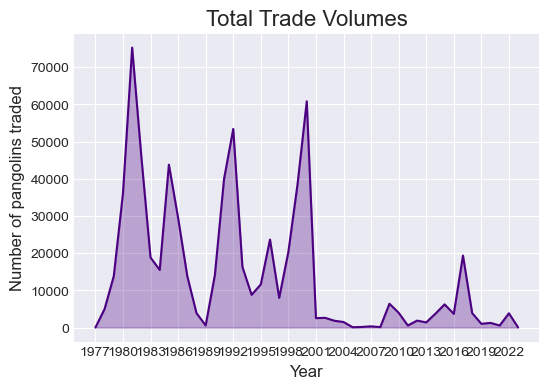

In [301]:
# Recall total trade volumes
plt.figure(figsize = (6,4))
plt.plot(total['Year'], total['Number'], color = 'indigo')
plt.title('Total Trade Volumes', fontsize = 16)
plt.fill_between(total['Year'], total['Number'], color = 'indigo', alpha = 0.3)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Number of pangolins traded', fontsize = 12)
plt.xticks(np.arange(min(total['Year']), max(total['Year'])+1, 3))
plt.style.use('seaborn-v0_8-darkgrid')

**Data**

Due to the zero-export quotas for wild-caught Asian pangolins imposed in 2000 (IUCN SSC Pangolin Specialist Group, 2016) there was a sharp decrease in the reported number of pangolins traded after 2000. However, there is little reason to assume that the demand for pangolin products decreased. In fact, there is evidence that illegal trading of pangolins increased (Wildlife Justice Commission, 2020).  For this reason, I will regard the data from before 2000 as more representative of the true trade volumes.  The Monte Carlo methods below will be based on this pre-2000 data.  We will therefore need to make predictions for 2001 to 2023, and for the next decade into the future, so until 2033.  

**Monte Carlo Parameters**

Parameters for the underlying probability distribution that generated the data will be calculated from the data using either maximum likelihood or method of moments.  As these parameters may not be exactly equal to the true parameter from the underlying distribution, I will consider any parameter values uniformly within 10% above or below the observed parameter when simulating values.

**Growth in Trade**

The Wildlife Justice Commission names a decreasing supply in elephant ivory and improved smuggling methods as some of the reasons behind the increase in trafficking of pangolin scales (Wildlife Justice Commission, 2020).  This increase in demand will need to be taken into account when making predictions.  I will assume a yearly increase in trade of between -1% to 3%.  A negative percentage is included to allow for years where demand decreases, as it is unlikely that demand will increase consistently every year. A uniform distribution will be used to select the yearly rates.

**Illegal Trade**

Finally, for the period of 1977 to 2000, unreported trade involved 'an additional, estimated 88% - 163%' of the reported trade (IUCN SSC Pangolin Specialist Group, 2016).  Therefore, an additional increase between 88% and 163% will be added to the predictions in order to produce predictions for the total number of pangolins traded both legally and illegally. 

In [331]:
# Set variables for simulation
n_pred = 10
n_years = len(post2000) + n_pred
n_sim = 1000
growth_min = 0.99
growth_max = 1.03
bins = range(0, int(pre2000['Number'].max()) + 2)

## 3. Motivation for Use of Monte Carlo Methods

In [303]:
# Check for trends in pre-2000 data using linear regression
linreg = sm.OLS(pre2000['Number'], sm.add_constant(pre2000['Year'])).fit()
linreg.pvalues

const    0.714969
Year     0.699847
dtype: float64

Linear regression of `Number` on `Year` gives a coefficient with a p-value of roughly 0.7.  This is statistically insignificant, and indicates that `Number` is not dependent on `Year`.  Therefore, we can assume that the volume of pangolins traded per year before 2000 does not depend on the year in which the trades took place.  We can regard the total amount traded per year as independent observations from the same underlying distribution.

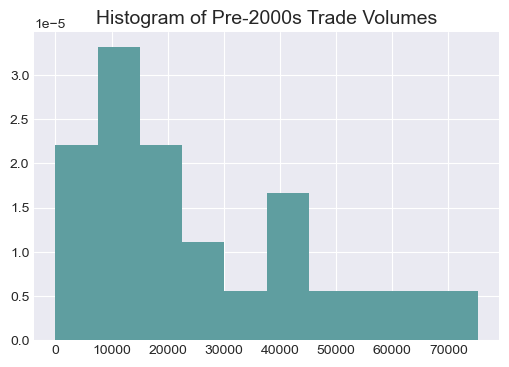

In [304]:
# Plot histogram of pre-2000s pangolins traded
plt.figure(figsize = (6,4))
plt.hist(pre2000['Number'], density = True, color = 'cadetblue')
plt.title('Histogram of Pre-2000s Trade Volumes', fontsize = 14)
plt.style.use('seaborn-v0_8-darkgrid')

The histogram is clearly skewed to the right, as we are dealing with non-negative count data.  There are several possible distributions that could be fitted to this data.  In the next section we will consider the following three:

- *Poisson distribution.*
- *Negative binomial distribution.*
- *Log-normal distribution.*

## 4. Choice of Underlying Distribution

Let us now fit a Poisson, negative binomial, and lognormal distribution to the pre-2000s data and select the one that provides the best fit.

### Fit the Poisson Distribution

In [332]:
# Calculate mean and variance of pre-2000s pangolins traded
mn = round(pre2000['Number'].mean(), 3)
vr = round(pre2000['Number'].var(), 3)

print('Mean:', mn, ', Variance:', vr)

Mean: 24909.458 , Variance: 406913647.129


The variance of the data is significantly larger than the mean, so it is greatly overdispersed.  This means that the Poisson distribution is not appropriate for the data as it is.  However, the values given are in tens of thousands.  By scaling the data we may reduce the difference between the mean and variance and find a Poisson distribution that is reasonably appropriate for the scaled data.  

The Poisson distribution requires for the mean and variance to be equal, in other words for the ratio of the variance to the mean to be close to 1.  Let us consider several possible values by which to scale the data.

In [306]:
# Possible scaling divisors
divisors = range(2000, 16000, 2000)

# Calculate ratio of variance to mean for each divisor
for i in range(0,len(divisors)):
    check_div = pre2000['Number']/divisors[i]
    check_mn = check_div.mean()
    check_vr = check_div.var()
    check_ratio = round(check_vr/check_mn, 3)
    print(divisors[i], ':', check_ratio)

2000 : 8.168
4000 : 4.084
6000 : 2.723
8000 : 2.042
10000 : 1.634
12000 : 1.361
14000 : 1.167


The lowest ratio is 1.167.  This was found when we divided the original data by 14 000.  However, the predictions we make using the scaled data will be in multiples of the divisor, so we cannot use too large a divisor or else we risk distorting the results.  Therefore, I will select a divisor of 10 000.  It gives a ratio of variance to mean that is below 2, while not oversimplifying the original data. 

Let us now fit a Poisson distribution to the rescaled data.  The maximum likelihood estimate of the rate parameter $\lambda$ for a Poisson distribution is $\hat{\lambda} = \frac{1}{N} \sum_{i=1}^N x_i$, where $N$ is the total number of observations and the $x_i$ are the observed values.  In other words, $\hat{\lambda} = \bar{x}$, the sample mean.

In [307]:
# Select divisor and scale the data
divisor = 10000
ps_div = pre2000['Number'] / divisor

# Calculate mean and range of data
ps_mn = round(ps_div.mean(), 3)
ps_vr = round(ps_div.var(), 3)
ps_bins = range(0, int(ps_div.max()) + 2)

print('Scaled mean:', ps_mn, ', Scaled variance:', ps_vr)

Scaled mean: 2.491 , Scaled variance: 4.069


The scaled mean and variance are much closer to each other.  Let us examine the fit of this distribution visually.

Text(0.5, 1.0, 'Poisson Density Fitted to Scaled Pre-2000s Trade Volumes')

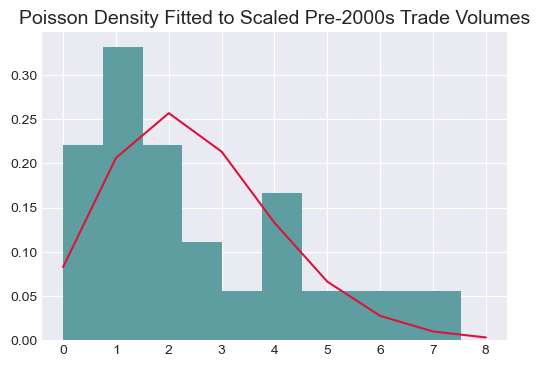

In [308]:
# Plot the fitted Poisson distribution to the data
plt.figure(figsize = (6,4))
plt.hist(ps_div, density = True, color = 'cadetblue')
plt.plot(ps_bins, poisson.pmf(ps_bins, ps_mn), color = 'crimson')
plt.title('Poisson Density Fitted to Scaled Pre-2000s Trade Volumes', fontsize = 14)

The fit of the Poisson distribution to the data is somewhat reasonable, although it could use some improvement.

### Fit the Negative Binomial Distribution

The negative binomial distribution takes two parameters: $p$, the probability of success, and $k$, the stopping parameter.  The method of moments estimates of these two parameters are $\hat{p} = \frac{\bar{x}}{s^2}$ and $\hat{k} = \frac{\bar{x}^2}{s^2 - \bar{x}}$, using the sample mean $\bar{x}$ and sample variance $s^2$ from the data.

In [309]:
# Estimate parameters from data using method of moments
nb_p = mn/vr
nb_k = mn**2/(vr - mn)

Text(0.5, 1.0, 'Negative Binomial Density Fitted to Pre-2000s Trade Volumes')

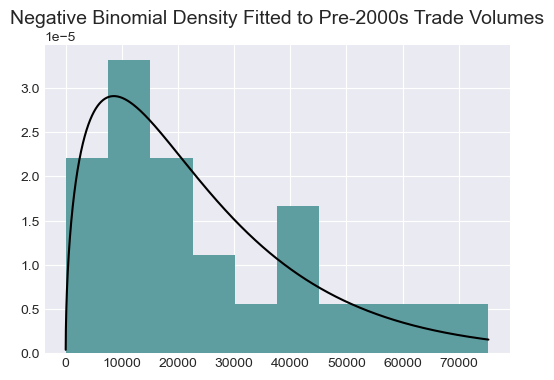

In [310]:
# Plot the fitted negative binomial distribution to the data
plt.figure(figsize = (6,4))
plt.hist(pre2000['Number'], density = True, color = 'cadetblue')
plt.plot(nbinom.pmf(bins, nb_k, nb_p), color = 'black')
plt.title('Negative Binomial Density Fitted to Pre-2000s Trade Volumes', fontsize = 14)

The negative binomial distribution provides a reasonably good fit to the data.

### Fit the Log-Normal Distribution

To fit this model, we will use the inbuilt `fit` function from the `scipy.stats` package.

In [311]:
# Fit the model using lognorm.fit
ln_shape, ln_loc, ln_scale = lognorm.fit(pre2000['Number'])
print([round(ln_shape, 3), round(ln_loc, 3), round(ln_scale, 3)])

[0.634, -7818.608, 27084.983]


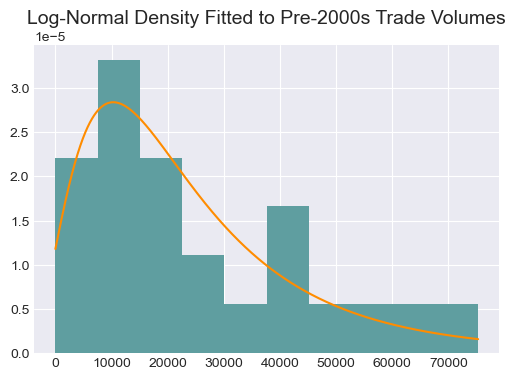

In [312]:
# Plot the fitted distribution against the data
plt.figure(figsize = (6,4))
plt.hist(pre2000['Number'], density = True, color = 'cadetblue')
plt.plot(lognorm.pdf(bins, ln_shape, ln_loc, ln_scale), color = 'darkorange')
plt.title('Log-Normal Density Fitted to Pre-2000s Trade Volumes', fontsize = 14)
plt.savefig('Images/fitted_log_norm_density.png')

The log-normal distribution also provides a good fit to the data.  It appears to be quite similar to the negative binomial.

### Comparison of Distributions

We need to select the best distribution of the three to use when simulating values.

**Quartile-Quartile Plots (QQ-plots)**

Let us begin by examining QQ-plots for each distribution.

In [313]:
# Generate samples from the fitted distributions
np.random.seed(23200776)
ps_rvs = poisson.rvs(ps_mn, size = 1000)
nb_rvs = nbinom.rvs(nb_k, nb_p, size = 1000)
ln_rvs = lognorm.rvs(ln_shape, ln_loc, ln_scale, 1000)

In [314]:
# Arrange the pre-2000s data in ascending order
num_ordered = pre2000['Number'].sort_values(ascending = True)
num_ordered = num_ordered/(num_ordered.max())

# Select quantiles
quant = np.arange(0, 1, 1/len(pre2000)) + 1/len(pre2000)
ps_quantiles = np.quantile(ps_rvs, quant)
nb_quantiles = np.quantile(nb_rvs, quant)
ln_quantiles = np.quantile(ln_rvs, quant)

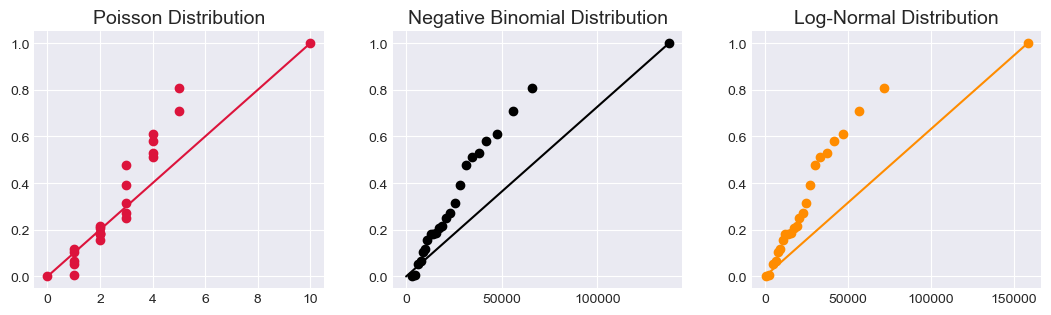

In [315]:
# Plot the different QQ-plots
fig, axs = plt.subplots(1,3)
axs[0].scatter(ps_quantiles, num_ordered, color = 'crimson')
axs[0].plot([0,ps_quantiles.max()], [0,1], color = 'crimson')
axs[0].set_title('Poisson Distribution', fontsize = 14)
axs[1].scatter(nb_quantiles, num_ordered, color = 'black')
axs[1].plot([0,nb_quantiles.max()], [0,1], color = 'black')
axs[1].set_title('Negative Binomial Distribution', fontsize = 14)
axs[2].scatter(ln_quantiles, num_ordered, color = 'darkorange')
axs[2].plot([0,ln_quantiles.max()], [0,1], color = 'darkorange')
axs[2].set_title('Log-Normal Distribution', fontsize = 14)
fig.tight_layout()
fig.set_figwidth(11)
fig.set_figheight(3)

Ideally, the points should lie perfectly along the diagonal line to indicate that the distribution is a perfect fit to the data.  Here, the distributions all appear to fit the data better in the lower percentiles, and deviate further as we reach the tails in every case.  We can also see that the negative binomial and log-normal distribution have provided very similar-looking QQ-plots.

**Kolmogorov-Smirnov Test**

Let us now use the Kolmogorov-Smirnov test to check if the data comes from each of the fitted distributions.  We use a two-sample test, with the randomly generated observations from the fitted distributions being the second sample in each case.  The null hypothesis of this test is that the two samples come from the same distribution.  The test statistic measures the largest vertical distance between the cumulative distribution functions of the two samples.  A lower test statistic is therefore preferred. Let us use a significance level of $\alpha$ = 0.05.

In [316]:
# Perform Kolmogorov-Smirnov tests 
ps_ks_test = kstest(pre2000['Number']/divisor, ps_rvs, args = (ps_mn,), alternative = 'two-sided')
nb_ks_test = kstest(pre2000['Number'], nb_rvs, args = (nb_k, nb_p), alternative = 'two-sided')
ln_ks_test = kstest(pre2000['Number'], ln_rvs, args = (ln_shape, ln_loc, ln_scale), alternative = 'two-sided')

# Print out p-values
print('Poisson p-value:', round(ps_ks_test.pvalue, 3))
print('Negative Binomial p-value:', round(nb_ks_test.pvalue, 3))
print('Log-Normal p-value:', round(ln_ks_test.pvalue, 3))

Poisson p-value: 0.079
Negative Binomial p-value: 0.95
Log-Normal p-value: 0.928


All three p-values are larger than our significance level of 0.05, indicating that we cannot reject the null hypothesis for any of the distributions.  There is insufficient evidence to conclude that the data is not from any of the three distributions.  However, the p-value for the Poisson distribution is 0.079, which is relatively close to 0.05.  For this reason we may choose to focus on only the negative binomial and log-normal distributions, as they may provide a better fit.  

In [317]:
# Print out Kolmogorov-Smirnov statistics
print('Poisson KS statistic:', round(ps_ks_test.statistic, 3))
print('Negative Binomial KS statistic:', round(nb_ks_test.statistic, 3))
print('Log-Normal KS statistic:', round(ln_ks_test.statistic, 3))

Poisson KS statistic: 0.255
Negative Binomial KS statistic: 0.101
Log-Normal KS statistic: 0.106


The negative binomial and log-normal distributions have similar Kolmogorov-Smirnov statistics.  The statistics are also smaller than that of the Poisson distribution.  Recall that a smaller test statistic implies a smaller distance between the cumulative distribution functions of the data and the underlying distribution, i.e. a better fit.  This indicates that the negative binomial and log-normal provide better fits to the data than the Poisson. 

**Bayesian Information Criterion**

As a final check, let us compare the BIC scores of the negative binomial and the log-normal distributions.  This check cannot be performed for the Poisson distribution, however we can already see that the Poisson is not the optimal distribution so we can ignore this one.  The formula for the BIC is:

$BIC = -2 \text{log}(L) + k\times \text{log}(n)$

where $\text{log}(L)$ is the log-likelihood, $k$ is the number of the parameters, and $n$ is the number of observations.  In order to maximise the log-likelihood we must select the distribution that gives the smallest BIC.

In [318]:
# Calculate log-likelihoods
nb_loglik = np.sum(np.log(nbinom.pmf(pre2000['Number'], nb_k, nb_p)))
ln_loglik = np.sum(np.log(lognorm.pdf(pre2000['Number'], ln_shape, ln_loc, ln_scale)))

# Calculate BIC
nb_bic = -2*nb_loglik + 2*np.log(len(pre2000))
ln_bic = -2*ln_loglik + 3*np.log(len(pre2000))

# Print results
print('Negative Binomial BIC:', round(nb_bic, 3))
print('Log-Normal BIC:', round(ln_bic, 3))

Negative Binomial BIC: 546.747
Log-Normal BIC: 545.688


We choose the log-normal distribution as it has the smallest BIC.

## 5. Monte Carlo Simulation

### Generate Predictions

Let us start by generating a range of parameter values, and then use these to simulate values from the log-normal distribution.

In [333]:
# Simulate values for the parameters using a uniform distribution
np.random.seed(23200776)
ln_shapes = np.random.uniform(ln_shape*0.9, ln_shape*1.1, n_years*n_sim)
ln_locs = np.random.uniform(ln_loc*0.9, ln_loc*1.1, n_years*n_sim)
ln_scales = np.random.uniform(ln_scale*0.9, ln_scale*1.1, n_years*n_sim)

In [334]:
# Simulate values from the log-normal distribution with the parameters above
np.random.seed(23200776)
ln_pred = lognorm.rvs(ln_shapes, ln_locs, ln_scales, n_years*n_sim).reshape(n_sim, n_years)
ln_past_pred = lognorm.rvs(ln_shape, ln_loc, ln_scale, len(pre2000)*n_sim).reshape(n_sim, len(pre2000))

### Include Growth Rates

Let us include growth rates as discussed in the 'Assumptions' subsection of the Introduction.

In [335]:
# Simulate growth rates using a uniform distribution
np.random.seed(23200776)
yearly_rates = np.random.uniform(growth_min, growth_max, (n_years-1)*n_sim).reshape(n_sim, n_years-1)
yearly_rates = np.hstack((np.ones(n_sim).reshape(n_sim, 1), yearly_rates))

# Find the cumulative growth rates
cum_rates = np.cumprod(yearly_rates, axis = 1)

In [336]:
# Multiply the simulated values by the cumulative growth rates
ln_growth_pred = np.multiply(ln_pred, cum_rates)

Let us plot the predictions so far.

In [337]:
# Create required objects for plotting
year_range = range(post2000['Year'].min(), post2000['Year'].max() + n_pred + 1)

# Average of predictions per year 
ln_growth_avg = ln_growth_pred.mean(axis = 0)
ln_past_avg = ln_past_pred.mean(axis = 0)

# Standard deviations of predictions per year
ln_growth_std_up = ln_growth_avg + ln_growth_pred.std(axis = 0)
ln_growth_std_low = ln_growth_avg - ln_growth_pred.std(axis = 0)

# 95% percentiles
ln_growth_95_low = np.percentile(ln_growth_pred, 2.5, axis = 0)
ln_growth_95_up = np.percentile(ln_growth_pred, 97.5, axis = 0)

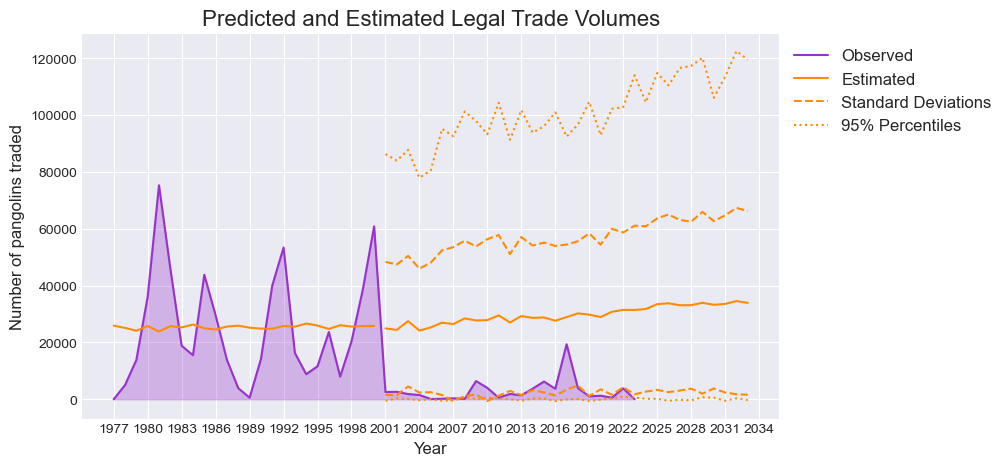

In [338]:
# Plot predictions
plt.figure(figsize = (9,5))
plt.plot(total['Year'], total['Number'], color = 'darkorchid', label = 'Observed')
plt.fill_between(total['Year'], total['Number'], color = 'darkorchid', alpha = 0.3)
plt.plot(year_range, ln_growth_avg, color = 'darkorange', label = 'Estimated')
plt.plot(pre2000['Year'], ln_past_avg, color = 'darkorange')
plt.plot(year_range, ln_growth_std_up, color = 'darkorange', linestyle = 'dashed', label = 'Standard Deviations')
plt.plot(year_range, ln_growth_std_low, color = 'darkorange', linestyle = 'dashed')
plt.plot(year_range, ln_growth_95_low, color = 'darkorange', linestyle = 'dotted', label = '95% Percentiles')
plt.plot(year_range, ln_growth_95_up, color = 'darkorange', linestyle = 'dotted')
plt.title('Predicted and Estimated Legal Trade Volumes', fontsize = 16)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Number of pangolins traded', fontsize = 12)
plt.legend(frameon = False, bbox_to_anchor = (1, 1), fontsize = 12)
plt.xticks(np.arange(min(total['Year']), max(total['Year'])+n_pred+2, 3))
plt.savefig('Images/predicted_legal.png', bbox_inches = 'tight')

The average of the predictions follows a gentle upward trend, as expected.  The standard deviations are evenly spaced from the average, while the 97.5% percentile is much further from the mean than the 2.5% percentile.  This reflects the shape of the negative binomial distribution, which has many lower values and fewer higher values.  For interest's sake, let us compare the average predicted number of pangolins poached between 1977 and 2000 to the observed number.

In [339]:
# Compare average predicted to total observed
total_pred = int(np.ceil(ln_past_avg.sum()))
total_obs = int(pre2000['Number'].sum())
total_diff = round(total_pred - total_obs, 3)
total_prop = round(total_diff/total_obs, 5)

# Print results
print('Predicted total number of pangolins poached between 1977 and 2000:', total_pred)
print('Observed total number of pangolins poached between 1977 and 2000: ', total_obs)
print('Difference:', total_diff)
print('Proportion of Observed:', total_prop)

Predicted total number of pangolins poached between 1977 and 2000: 609725
Observed total number of pangolins poached between 1977 and 2000:  597827
Difference: 11898
Proportion of Observed: 0.0199


The fitted log-normal distribution has estimated the total number of pangolins poached between 1977 and 2000 correct to about 12 000 pangolins, which is roughly 2% of the observed values.  This shows quite a high level of accuracy for the past data. 

### Extrapolate for Illegal Trade

Now that we have estimates for the past and future levels of legal trade, we can begin to factor in illegal trade.  As mentioned in the 'Assumptions' subsection of the Introduction, unreported trade in the period 1977 to 2000 was between 88% to 163% of the reported trade (IUCN SSC Pangolin Specialist Group, 2016).  As a final estimated range of the combined legal and illegal trade levels, both past and future, I will simply multiply the average predictions by 88% to 163%.

In [340]:
# Proportions of illegal trade
illegal_lower = 1 + 0.88
illegal_upper = 1 + 1.63
illegal_avg = (illegal_lower + illegal_upper)/2

# Scale up our predicted values
past_lower = ln_past_avg*illegal_lower
past_upper = ln_past_avg*illegal_upper
past_avg = ln_past_avg*illegal_avg
pred_lower = ln_growth_avg*illegal_lower
pred_upper = ln_growth_avg*illegal_upper
pred_avg = ln_growth_avg*illegal_avg

We will analyse these results in the next section.

## 6. Discussion

Let us first look at the plot of the total predicted pangolins traded.

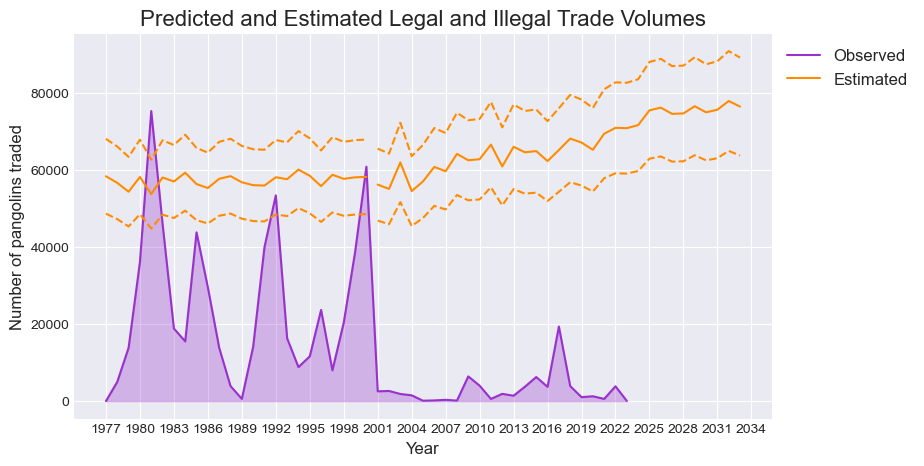

In [341]:
# Plot total predictions
plt.figure(figsize = (9,5))
plt.plot(total['Year'], total['Number'], color = 'darkorchid', label = 'Observed')
plt.fill_between(total['Year'], total['Number'], color = 'darkorchid', alpha = 0.3)
plt.plot(pre2000['Year'], past_avg, color = 'darkorange', label = 'Estimated')
plt.plot(pre2000['Year'], past_lower, color = 'darkorange', linestyle = 'dashed')
plt.plot(pre2000['Year'], past_upper, color = 'darkorange', linestyle = 'dashed')
plt.plot(year_range, pred_avg, color = 'darkorange')
plt.plot(year_range, pred_lower, color = 'darkorange', linestyle = 'dashed')
plt.plot(year_range, pred_upper, color = 'darkorange', linestyle = 'dashed')
plt.title('Predicted and Estimated Legal and Illegal Trade Volumes', fontsize = 16)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Number of pangolins traded', fontsize = 12)
plt.legend(frameon = False, bbox_to_anchor = (1, 1), fontsize = 12)
plt.xticks(np.arange(min(total['Year']), max(total['Year'])+n_pred+2, 3))
plt.savefig('Images/predicted_total.png', bbox_inches = 'tight')

It appears that the true number of pangolins traded is much higher than what was reported.  Let us examine some numbers.

In [343]:
# Find totals for different time periods
total_past_lower = int(np.ceil(past_lower.sum()))
total_past_upper = int(np.ceil(past_upper.sum()))
total_past_avg = int(np.ceil(past_avg.sum()))
total_current_lower = int(np.ceil(pred_lower[0:len(post2000)+1].sum()))
total_current_upper = int(np.ceil(pred_upper[0:len(post2000)+1].sum()))
total_current_avg = int(np.ceil(pred_avg[0:len(post2000)+1].sum()))
total_future_lower = int(np.ceil(pred_lower[len(post2000)+1:].sum())) 
total_future_upper = int(np.ceil(pred_upper[len(post2000)+1:].sum())) 
total_future_avg = int(np.ceil(pred_avg[len(post2000)+1:].sum()))

# Print out results
pd.DataFrame([[f"{total_past_lower:,}", f"{total_current_lower:,}", f"{total_future_lower:,}"], 
              [f"{total_past_avg:,}", f"{total_current_avg:,}", f"{total_future_avg:,}"], 
              [f"{total_past_upper:,}", f"{total_current_upper:,}", f"{total_future_upper:,}"]], 
             columns = ['1977 - 2000', '2001 - 2023', '2023 - 2033'], index = ['Lower bound', 'Expected', 'Upper bound'])

,1977 - 2000,2001 - 2023,2023 - 2033
Lower bound,"1,146,283","1,274,276","568,893"
Expected,"1,374,930","1,528,453","682,369"
Upper bound,"1,603,577","1,782,630","795,844"


The total expected number of pangolins traded between 1977 and 2000 is 1 374 930.  The period 2001 to 2023 shows an increase to 1 528 453 pangolins.  By these estimates there have been almost 3 million pangolins killed for trading purposes over the last 50 or so years.  This is an unsustainable rate of consumption, and undoubtedly a major contributing factor in the endangerment of wild pangolin populations.  The demand shows no signs of slowing down.  

Let us also use the total trades to estimate the number of pangolins that have been traded illegally between 1977 and 2023.

In [344]:
# Calculate number of legally traded pangolins
legal_pre2000 = int(np.ceil(pre2000['Number'].sum()))
legal_post2000 = int(np.ceil(post2000['Number'].sum()))

# Estimate number of illegally traded pangolins and print
pd.DataFrame([[f"{total_past_lower - legal_pre2000:,}", f"{total_current_lower - legal_post2000:,}"], 
              [f"{total_past_avg - legal_pre2000:,}", f"{total_current_avg - legal_post2000:,}"], 
              [f"{total_past_upper - legal_pre2000:,}", f"{total_current_upper - legal_post2000:,}"]], 
             columns = ['1977 - 2000', '2001 - 2023'], index = ['Lower bound', 'Expected', 'Upper bound'])

,1977 - 2000,2001 - 2023
Lower bound,"548,456","1,207,165"
Expected,"777,103","1,461,342"
Upper bound,"1,005,750","1,715,519"


Illicit trade in pangolins between 2000 and 2014 was 'estimated to involve 1,000,000 animals' (IUCN SSC Pangolin Specialist Group, 2016).  Our estimates reflect similar numbers, with around 1.5 million animals being traded illegally between 2000 and 2023.  There was a marked increase in illegal trade after 2000, with almost double the number of pangolins traded illegally after 2000 compared to before 2000, despite the time periods being the same length.  This is undoubtedly due at least in part to the trade restrictions imposed. 

## 7. Concluding Remarks

In this assignment we have seen that the consumption of pangolins was concentrated in Asian pangolin species, but in recent years has included more African species.  Skins and related products such as scales form the majority of the items traded, and the United States is the largest recorded importer of pangolin products.  Overall, pangolin trading has had devastating effects on the pangolin population and will continue to do so for the forseeable future.  These peaceful creatures are more at risk than ever.  It is critically important to support conservation efforts before it is too late. 

## 8. References 

1. IUCN SSC Pangolin Specialist Group. (2016, January 11). THE CONSERVATION STATUS, ILLEGAL TRADE AND USE OF PANGOLINS (MANIS SPP.) - Information Document for the 66th Meeting of the CITES Standing Committee. Retrieved from CITES.org: https://cites.org/sites/default/files/eng/com/sc/66/Inf/E-SC66-Inf-23.pdf
2. Wildlife Justice Commission. (2020, February). Scaling up: The Rapid Growth in the Industrial Scale Trafficking of Pangolin Scales. Retrieved from Wildlife Justice Commission: https://wildlifejustice.org/wp-content/uploads/2020/02/The_Rapid_Growth_in_the_Trafficking_of_Pangolin_Scales_2015-2019-Update1.pdf